1. Import libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

In [ ]:
!pip install lightning --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 46.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid", font_scale=1.5, font="SimHei", rc={"axes.unicode_minus":False})

import torch
import torchmetrics
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models

import lightning.pytorch as pl
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
pl.seed_everything(seed)

INFO: Seed set to 1
INFO:lightning.fabric.utilities.seed:Seed set to 1


1

2. Read and preprocess dataset

In [ ]:
batch_size = 64

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = datasets.CIFAR10(root="./data", train=True, transform=train_transform, download=True)
val_dataset, test_dataset = torch.utils.data.random_split(datasets.CIFAR10(root="./data", train=False, transform=test_transform, download=True), [5000, 5000])

val_dataset.dataset.transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



100%|██████████| 170498071/170498071 [00:13<00:00, 12893506.78it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


3. Visuallize the train set

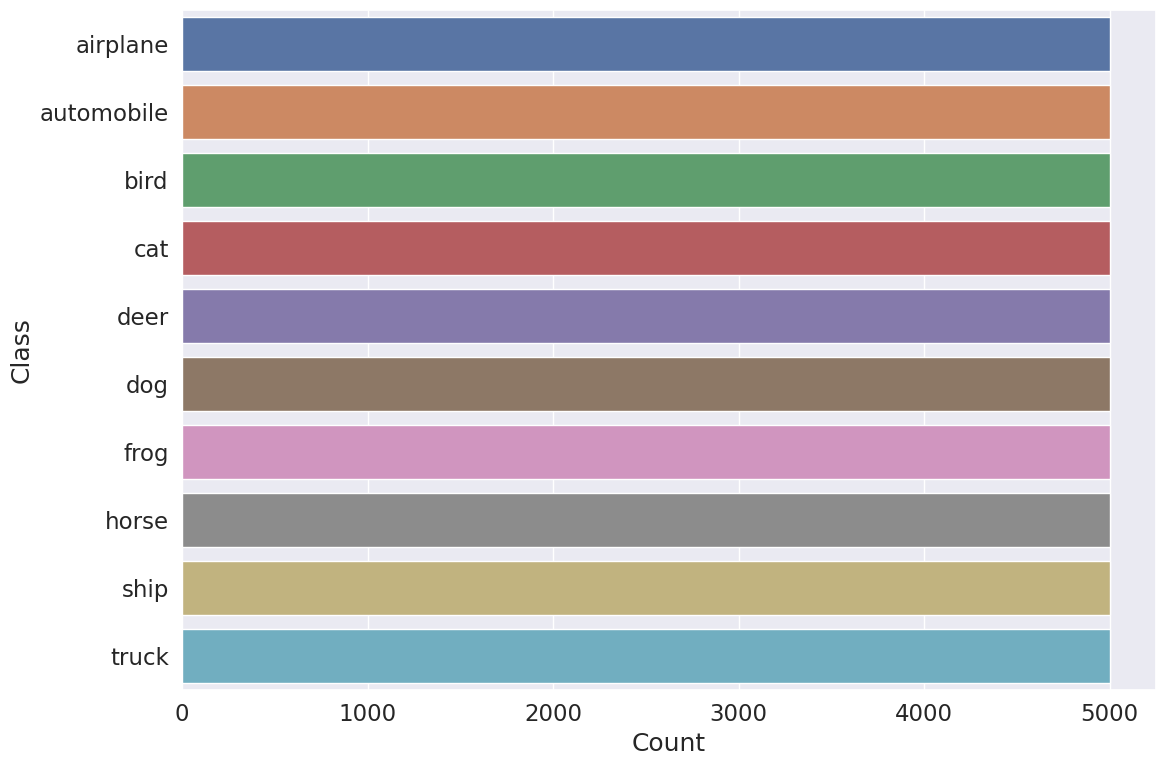

In [ ]:
class_names = train_dataset.classes
class_count = [train_dataset.targets.count(i) for i in range(len(class_names))]
df = pd.DataFrame({"Class": class_names, "Count": class_count})

plt.figure(figsize=(12, 8), dpi=100)
sns.barplot(x="Count", y="Class", data=df)
plt.tight_layout()
plt.show()

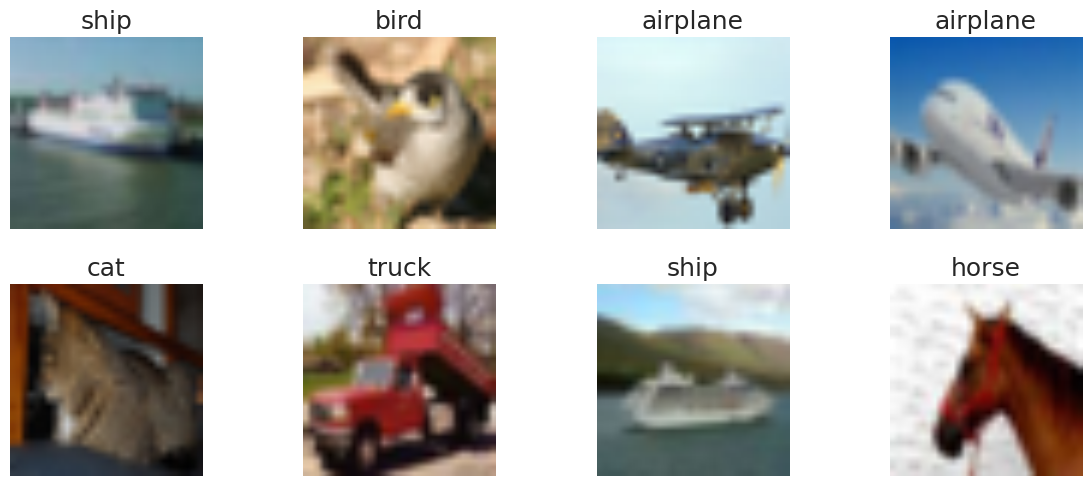

In [ ]:
plt.figure(figsize=(12, 20), dpi=100)
images, labels = next(iter(train_loader))
for i in range(8):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(images[i].permute(1, 2, 0).numpy())
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.tight_layout()
plt.show()

4. Create a module to train a pretrained model.

In [ ]:
class LitModel(pl.LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()
        self.model = models.mnasnet1_3(weights="IMAGENET1K_V1")
#         for param in self.model.parameters():
#             param.requires_grad = False
        self.model.classifier[1] = nn.Linear(1280, num_classes)
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        x = self.model(x)
        return x

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001, betas=(0.9, 0.99), eps=1e-08, weight_decay=1e-5)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.log('train_loss', loss, on_step=True, on_epoch=False, prog_bar=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=False, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True, logger=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        acc = self.accuracy(y_hat, y)
        self.log('test_acc', acc)

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        x, y = batch
        y_hat = self(x)
        preds = torch.argmax(y_hat, dim=1)
        return preds

4.1 Train the model using trainer.fit()

In [ ]:
model = LitModel.load_from_checkpoint("/content/drive/MyDrive/checkpoint2.ckpt")
# model = LitModel(10)
logger = CSVLogger("./")
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=5, verbose=False, mode="min")
trainer = pl.Trainer(max_epochs=20, enable_progress_bar=True, logger=logger, callbacks=[early_stop_callback])
# trainer.fit(model, train_loader, val_loader)

Downloading: "https://download.pytorch.org/models/mnasnet1_3-a4c69d6f.pth" to /root/.cache/torch/hub/checkpoints/mnasnet1_3-a4c69d6f.pth
100%|██████████| 24.2M/24.2M [00:00<00:00, 152MB/s]
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


5. Predict the test set

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

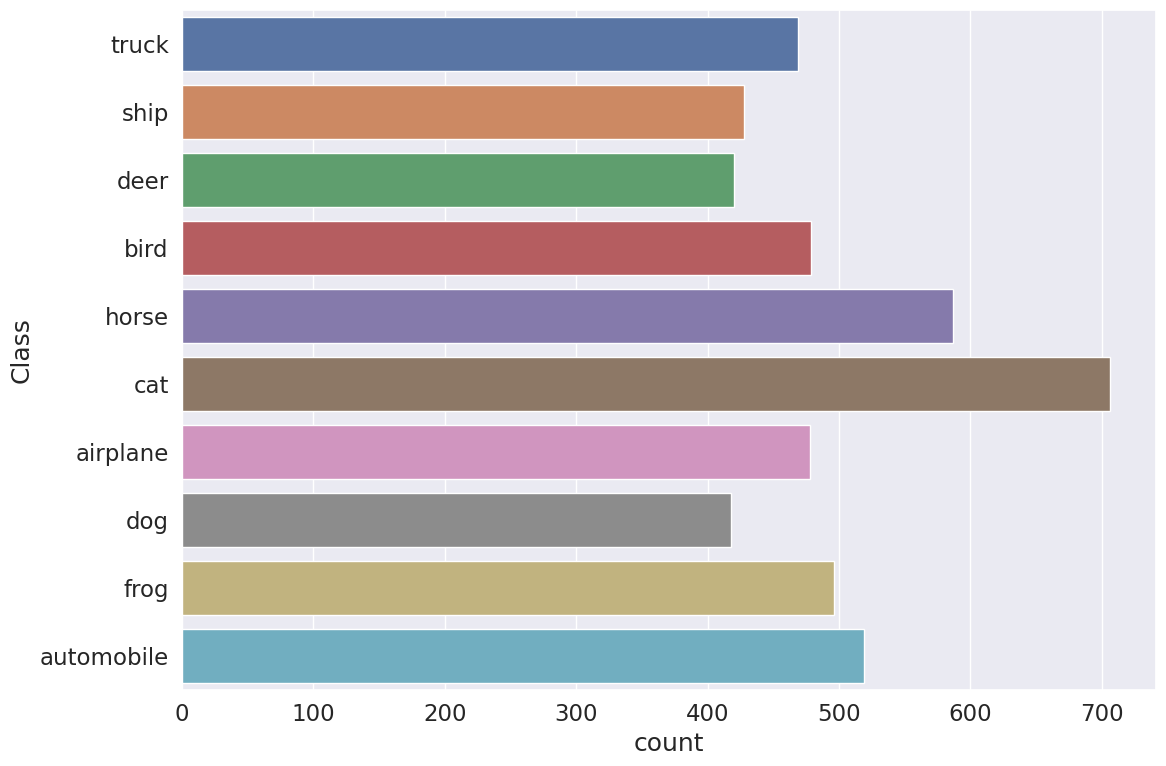

In [ ]:
pred = trainer.predict(model, test_loader)
pred = torch.cat(pred, dim=0)
pred = pd.DataFrame(pred.numpy(), columns=["Class"])
pred["Class"] = pred["Class"].apply(lambda x: class_names[x])

plt.figure(figsize=(12, 8), dpi=100)
sns.countplot(y="Class", data=pred)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/predicted_features.png")
plt.show()

6. Evaluation process

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

actual_labels = []

for batch in test_loader:
    images, labels = batch
    actual_labels.extend(labels.numpy())

actual_df = pd.DataFrame({"actual_column": actual_labels})

# Convert the actual labels to the same format as the predicted labels
actual_df["Class"] = actual_df["actual_column"].apply(lambda x: class_names[x])

# Calculate accuracy
accuracy = accuracy_score(actual_df["Class"], pred["Class"])

#Calculate precision
precision = precision_score(actual_df["Class"], pred["Class"], average='weighted')  # You can choose 'micro', 'macro', or 'weighted' depending on your requirements

#Calculate recall
recall = recall_score(actual_df["Class"], pred["Class"], average='weighted')

#Calculate specificity
f1 = f1_score(actual_df["Class"], pred["Class"], average='weighted')



print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")




Accuracy: 88.58%
Precision: 89.85%
Recall: 88.58%
F1 Score: 88.79%


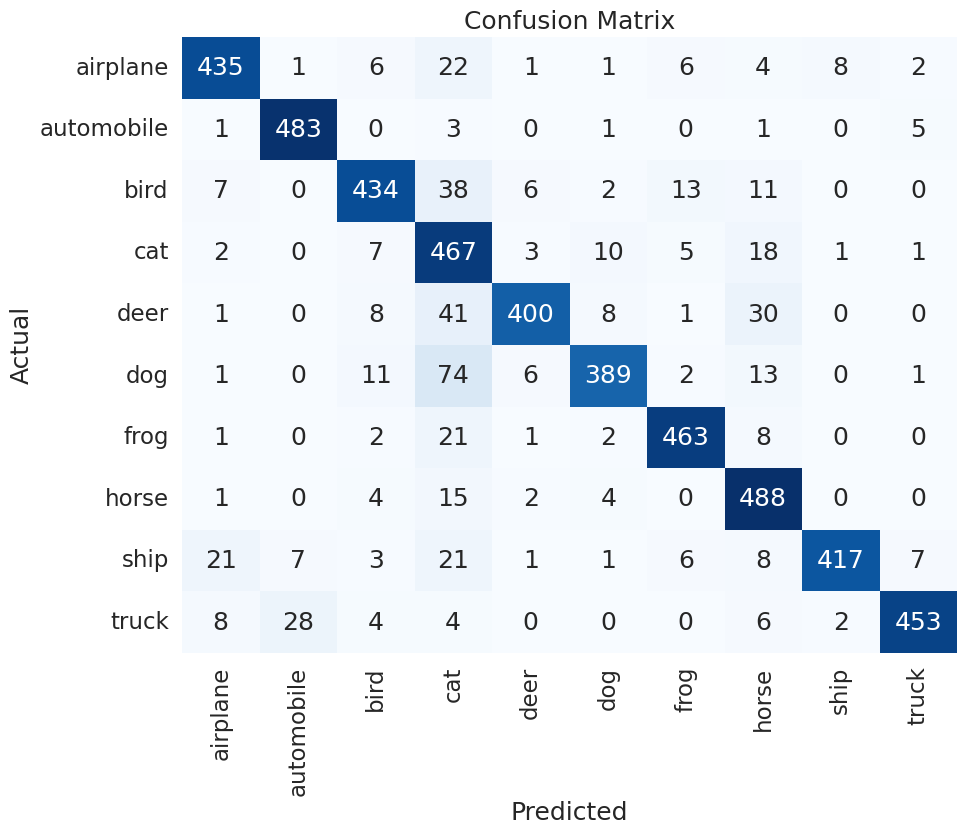

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

actual_labels = []

for batch in test_loader:
    images, labels = batch
    actual_labels.extend(labels.numpy())

actual_df = pd.DataFrame({"actual_column": actual_labels})

# Convert the actual labels to the same format as the predicted labels
actual_df["Class"] = actual_df["actual_column"].apply(lambda x: class_names[x])

# Calculate confusion matrix
cm = confusion_matrix(actual_df["Class"], pred["Class"])

# Create a DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig("/content/drive/MyDrive/confusion_matrix.png")
plt.show()



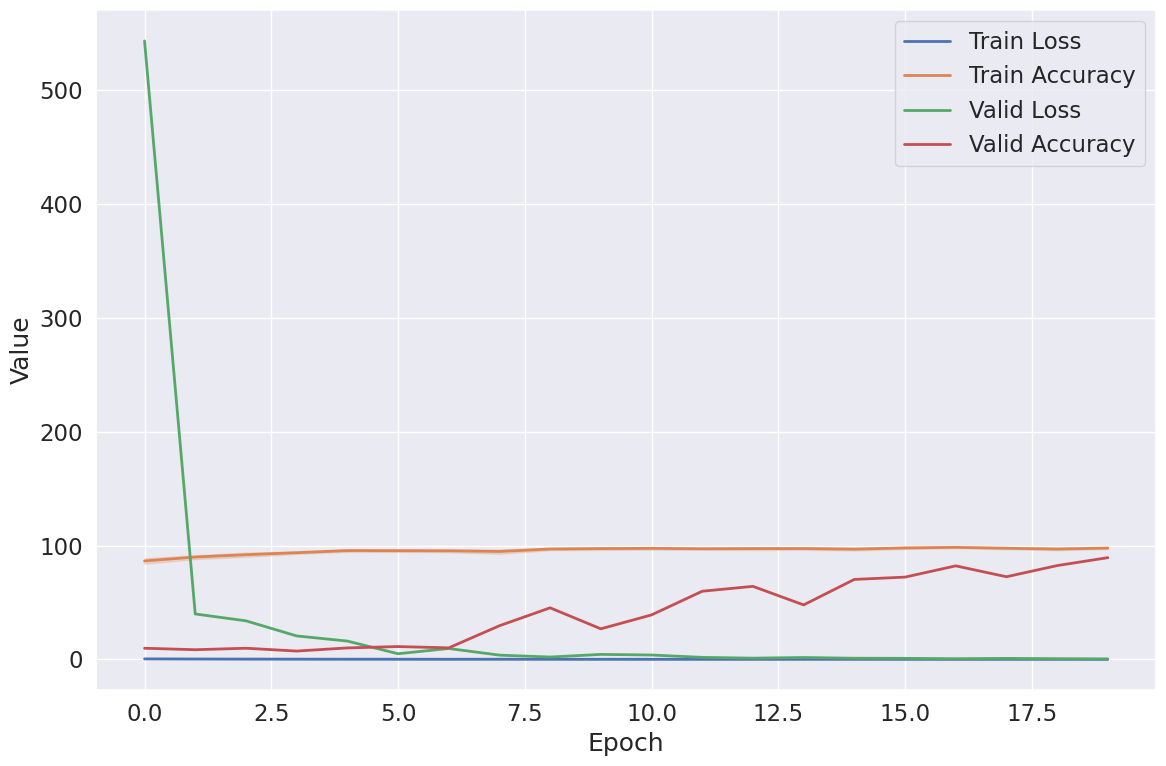

In [ ]:
log_path = "/content/drive/MyDrive/metrics.csv"
metrics = pd.read_csv(log_path)

# Multiply accuracy values by 100
metrics['train_acc'] *= 100
metrics['val_acc'] *= 100

plt.figure(figsize=(12, 8), dpi=100)
sns.lineplot(x="epoch", y="train_loss", data=metrics, label="Train Loss", linewidth=2)
sns.lineplot(x="epoch", y="train_acc", data=metrics, label="Train Accuracy", linewidth=2)
sns.lineplot(x="epoch", y="val_loss", data=metrics, label="Valid Loss", linewidth=2)
sns.lineplot(x="epoch", y="val_acc", data=metrics, label="Valid Accuracy", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/value_per_epoch.png")
plt.show()
